<a href="https://colab.research.google.com/github/saianish47/Twitter-Data-Analysis/blob/Pyspark/Twitter_Data_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip3 install pyspark

In [3]:
import pyspark
import re
from nltk.stem import PorterStemmer
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnull, when, count, col, udf
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import NaiveBayes, DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [4]:
spark = SparkSession \
    .builder \
    .appName('Twitter Data') \
    .getOrCreate()

In [5]:
spark

In [6]:
df = (spark.read.format("csv").option('header', 'true').load("data_all.csv"))

In [7]:
df.show(5)

+---+-----+--------------------+
|_c0|class|               tweet|
+---+-----+--------------------+
|  0|    0|!!! RT @mayasolov...|
|  1|    1|!!!!! RT @mleew17...|
|  2|    1|!!!!!!! RT @UrKin...|
|  3|    1|!!!!!!!!! RT @C_G...|
|  4|    1|!!!!!!!!!!!!! RT ...|
+---+-----+--------------------+
only showing top 5 rows



In [8]:
df.count()

125514

In [9]:
df.columns

['_c0', 'class', 'tweet']

In [10]:
df.dtypes

[('_c0', 'string'), ('class', 'string'), ('tweet', 'string')]

In [11]:
df.describe()

DataFrame[summary: string, _c0: string, class: string, tweet: string]

In [12]:
dataset = df.select(col('_c0').cast('int'), col('class').cast('int'), col('tweet'))
dataset.show()

+----+-----+--------------------+
| _c0|class|               tweet|
+----+-----+--------------------+
|   0|    0|!!! RT @mayasolov...|
|   1|    1|!!!!! RT @mleew17...|
|   2|    1|!!!!!!! RT @UrKin...|
|   3|    1|!!!!!!!!! RT @C_G...|
|   4|    1|!!!!!!!!!!!!! RT ...|
|   5|    1|"!!!!!!!!!!!!!!!!...|
|   6|    1|"!!!!!!""@__Brigh...|
|   7|    1|!!!!&#8220;@selfi...|
|   8|    1|""" &amp; you mig...|
|   9|    1|""" @rhythmixx_ :...|
|NULL| NULL|                NULL|
|  10|    1|""" Keeks is a bi...|
|  11|    1|""" Murda Gang bi...|
|  12|    1|""" So hoes that ...|
|  13|    1|""" bad bitches i...|
|  14|    1|""" bitch get up ...|
|  15|    1|""" bitch nigga m...|
|  16|    1|""" bitch plz wha...|
|  17|    1|""" bitch who do ...|
|  18|    1|""" bitches get c...|
+----+-----+--------------------+
only showing top 20 rows



In [13]:
dataset.select([count(when(isnull(c), c)).alias(c) for c in dataset.columns]).show()

+----+-----+-----+
| _c0|class|tweet|
+----+-----+-----+
|3203| 3359| 3286|
+----+-----+-----+



In [14]:
dataset = dataset.replace('RT', None).replace('&amp;','and').dropna(how='any').dropDuplicates()

In [15]:
dataset.count()

122151

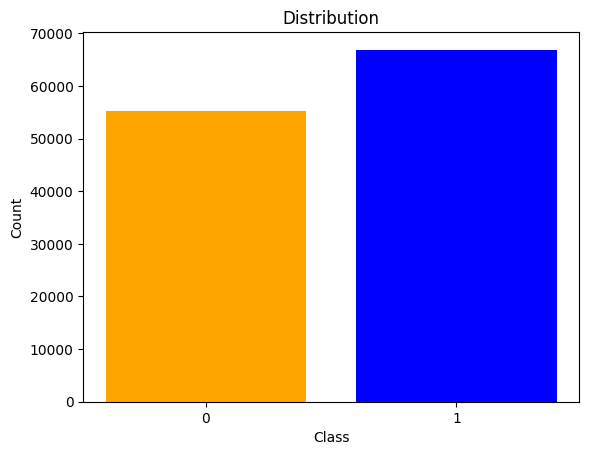

In [16]:
pandas_df = dataset.groupBy('class').count().toPandas()

plt.bar(pandas_df['class'], pandas_df['count'], color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution')
plt.xticks(pandas_df['class'])
plt.show()

In [17]:
abbreviation_dict = {'luv': 'love', 'wud': 'would', 'lyk': 'like', 'wateva': 'whatever', 'ttyl': 'talk to you later',
                     'kul': 'cool', 'fyn': 'fine', 'omg': 'oh my god!', 'fam': 'family', 'bruh': 'brother',
                     'cud': 'could', 'fud': 'food', 'abt': 'about', 'tbh': 'to be honest', 'dis': 'this',
                     'wtv': 'whatever', 'kk': 'okay'}

def clean_tweet(text):

    text = re.sub(r'@', '', text)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    for key, value in abbreviation_dict.items():
        text = text.replace(key, value)

    return text

clean_tweet_udf = udf(clean_tweet, StringType())

clean_tweet_udf = udf(clean_tweet)

dataset = dataset.withColumn('tweet', clean_tweet_udf(col('tweet')))

In [18]:
dataset.show(5)

+----+-----+--------------------+
| _c0|class|               tweet|
+----+-----+--------------------+
| 412|    1|trutherbot does h...|
| 505|    1|Im downloading yo...|
| 892|    0|pornandroidiphone...|
|1061|    1| RT ThatMclovin Y...|
|1102|    1|BINKO Denzy tryna...|
+----+-----+--------------------+
only showing top 5 rows



In [19]:
dataset.head(1)[0]

Row(_c0=0, class=0, tweet=' RT mayasolovely As a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out')

In [20]:
dataset.show(5)

+----+-----+--------------------+
| _c0|class|               tweet|
+----+-----+--------------------+
| 412|    1|trutherbot does h...|
| 505|    1|Im downloading yo...|
| 892|    0|pornandroidiphone...|
|1061|    1| RT ThatMclovin Y...|
|1102|    1|BINKO Denzy tryna...|
+----+-----+--------------------+
only showing top 5 rows



In [21]:
dataset = dataset.withColumnRenamed("clean_tweet_string", "tweet")

In [22]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
dataset = tokenizer.transform(dataset)

In [23]:
dataset.show(5)

+----+-----+--------------------+--------------------+
| _c0|class|               tweet|               words|
+----+-----+--------------------+--------------------+
| 412|    1|trutherbot does h...|[trutherbot, does...|
| 505|    1|Im downloading yo...|[im, downloading,...|
| 892|    0|pornandroidiphone...|[pornandroidiphon...|
|1061|    1| RT ThatMclovin Y...|[, rt, thatmclovi...|
|1102|    1|BINKO Denzy tryna...|[binko, denzy, tr...|
+----+-----+--------------------+--------------------+
only showing top 5 rows



In [24]:
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="clean_tweet")

porter_stemmer = PorterStemmer()

def apply_stemmer(words):
    return [porter_stemmer.stem(word) for word in words]

stemmer_udf = udf(apply_stemmer, ArrayType(StringType()))

dataset = stopwords_remover.transform(dataset)

dataset = dataset.withColumn('clean_tweet', stemmer_udf(col('clean_tweet')))

dataset.show(5, truncate=False)

+----+-----+----------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+
|_c0 |class|tweet                                                                                                                             |words                                                                                                                                                        |clean_tweet                                                                                     |
+----+-----+----------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------

In [25]:
dataset.show(5)

+----+-----+--------------------+--------------------+--------------------+
| _c0|class|               tweet|               words|         clean_tweet|
+----+-----+--------------------+--------------------+--------------------+
| 412|    1|trutherbot does h...|[trutherbot, does...|[trutherbot, look...|
| 505|    1|Im downloading yo...|[im, downloading,...|[im, download, ne...|
| 892|    0|pornandroidiphone...|[pornandroidiphon...|[pornandroidiphon...|
|1061|    1| RT ThatMclovin Y...|[, rt, thatmclovi...|[, rt, thatmclovi...|
|1102|    1|BINKO Denzy tryna...|[binko, denzy, tr...|[binko, denzi, tr...|
+----+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [26]:
dataset = dataset.drop('tweet', 'words')

In [27]:
dataset.show(5, truncate=False)

+----+-----+------------------------------------------------------------------------------------------------+
|_c0 |class|clean_tweet                                                                                     |
+----+-----+------------------------------------------------------------------------------------------------+
|412 |1    |[trutherbot, look, like, bitch, elcapacitor]                                                    |
|505 |1    |[im, download, new, person, order, new, face, bitch, love, goddamn, axl, rose, yell, sex, robot]|
|892 |0    |[pornandroidiphoneipadsexxxx, , desi, , paki]                                                   |
|1061|1    |[, rt, thatmclovin, yass, bitch, yass, , viokayinosecret, soon]                                 |
|1102|1    |[binko, denzi, tryna, hoe, broski, izzi]                                                        |
+----+-----+------------------------------------------------------------------------------------------------+
only showi

In [28]:
# hashingTF = HashingTF(inputCol="clean_tweet", outputCol="features", numFeatures=1000)
# featurized_data = hashingTF.transform(dataset)
# idf = IDF(inputCol="features", outputCol="IDFfeatures")
# idf_model = idf.fit(featurized_data)
# tfidf_data = idf_model.transform(featurized_data)

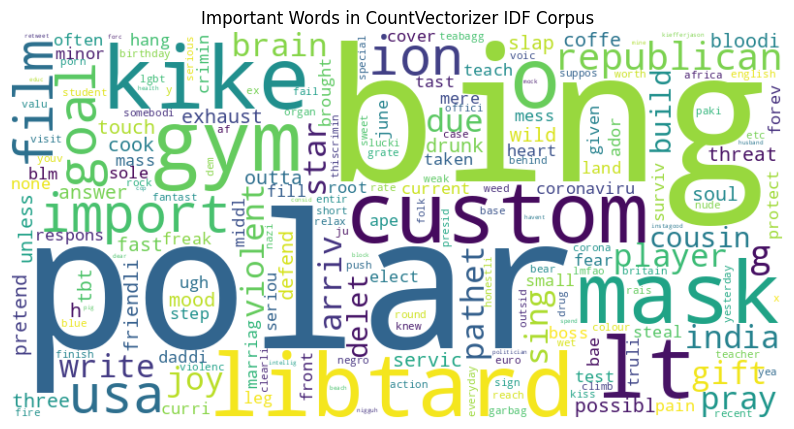

In [29]:
count_vectorizer = CountVectorizer(inputCol="clean_tweet", outputCol="rawFeatures", vocabSize=1000, minDF=10)
cv_model = count_vectorizer.fit(dataset)
featurized_data = cv_model.transform(dataset)

idf = IDF(inputCol="rawFeatures", outputCol="idf_features")
idf_model = idf.fit(featurized_data)
tfidf_data = idf_model.transform(featurized_data)


imp_words = idf_model.idf.toArray()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(cv_model.vocabulary, imp_words)))

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Important Words in CountVectorizer IDF Corpus')
plt.show()

In [30]:
tfidf_data.show(5, truncate=False)

+----+-----+------------------------------------------------------------------------------------------------+--------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|_c0 |class|clean_tweet                                                                                     |rawFeatures                                                         |idf_features                                                                                                                                                                         |
+----+-----+------------------------------------------------------------------------------------------------+--------------------------------------------------------------------+----------------------------------------------------------------------------------------------------

In [31]:
label_indexer = StringIndexer(inputCol="class", outputCol="indexedLabel").fit(tfidf_data)
tfidf_data = label_indexer.transform(tfidf_data)

In [32]:
(training_data, test_data) = tfidf_data.randomSplit([0.8,0.2])

In [33]:
training_data.show(5)

+---+-----+--------------------+--------------------+--------------------+------------+
|_c0|class|         clean_tweet|         rawFeatures|        idf_features|indexedLabel|
+---+-----+--------------------+--------------------+--------------------+------------+
|  1|    1|[, rt, mleew, boy...|(1000,[0,3,7,77,1...|(1000,[0,3,7,77,1...|         0.0|
|  2|    0|[, , bihday, maje...|(1000,[0,168],[2....|(1000,[0,168],[2....|         1.0|
|  3|    0|[model, , , love,...|(1000,[0,8,24,29,...|(1000,[0,8,24,29,...|         1.0|
|  3|    1|[, rt, cganderson...|(1000,[0,3,4,27,4...|(1000,[0,3,4,27,4...|         0.0|
|  3|    1|     [dalit, lowliv]|        (1000,[],[])|        (1000,[],[])|         0.0|
+---+-----+--------------------+--------------------+--------------------+------------+
only showing top 5 rows



In [34]:
training_data.columns

['_c0', 'class', 'clean_tweet', 'rawFeatures', 'idf_features', 'indexedLabel']

In [35]:
training_data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- class: integer (nullable = true)
 |-- clean_tweet: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- idf_features: vector (nullable = true)
 |-- indexedLabel: double (nullable = false)



In [36]:
class_counts = training_data.groupBy("class").count().orderBy("class")
class_counts.show()

+-----+-----+
|class|count|
+-----+-----+
|    0|44335|
|    1|53543|
+-----+-----+



In [37]:
# pipeline = Pipeline(stages=[tokenizer,stopwords_remover, hashingTF, idf, nb])


def crossValidation(estimator, noFolds):
  param_grid = ParamGridBuilder().build()

  cross_validator = CrossValidator(estimator=estimator, estimatorParamMaps=param_grid, evaluator=MulticlassClassificationEvaluator(labelCol="indexedLabel"),
                                  numFolds=noFolds)

  model = cross_validator.fit(training_data)

  return model




In [38]:
#Naive Bayes


nb_classifier = NaiveBayes(featuresCol="idf_features", labelCol="indexedLabel", predictionCol="prediction", probabilityCol="probability")

nbModel = crossValidation(nb_classifier, 5)
best_model = nbModel.bestModel

predictions = best_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7927738639640753


In [39]:
#Decision Tree

dt_classifier = DecisionTreeClassifier(featuresCol="idf_features", labelCol="indexedLabel", predictionCol="prediction")


dtModel = crossValidation(dt_classifier, 5)
best_model = dtModel.bestModel

predictions = best_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7247970996580563


In [40]:
#Random Forest

rf_classifier = RandomForestClassifier(featuresCol="idf_features", labelCol="indexedLabel", predictionCol="prediction", numTrees=100)


rfModel = crossValidation(rf_classifier, 5)
best_model = rfModel.bestModel

predictions = best_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.7371565113500598


In [46]:
#Logistic Regression

lr_classifier = LogisticRegression(featuresCol="idf_features", labelCol="indexedLabel", predictionCol="prediction")


lrModel = crossValidation(lr_classifier, 5)
best_model = lrModel.bestModel

predictions = best_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.8263090676883781


In [42]:

# param_grid = ParamGridBuilder().build()


# cross_validator = CrossValidator(estimator=rf_classifier,
#                                  estimatorParamMaps=param_grid,
#                                  evaluator=MulticlassClassificationEvaluator(labelCol="indexedLabel"),
#                                  numFolds=5)


# model = cross_validator.fit(training_data)

# cv_results = model.avgMetrics

In [43]:
# best_model = model.bestModel

# predictions = best_model.transform(test_data)

# evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
# accuracy = evaluator.evaluate(predictions)
# print(f"Test Accuracy: {accuracy}")

In [44]:
# param_grid = ParamGridBuilder().build()


# cross_validator = CrossValidator(estimator=lr_classifier,
#                                  estimatorParamMaps=param_grid,
#                                  evaluator=MulticlassClassificationEvaluator(labelCol="indexedLabel"),
#                                  numFolds=5)


# model = cross_validator.fit(training_data)


# cv_results = model.avgMetrics

In [45]:
# best_model = model.bestModel

# predictions = best_model.transform(test_data)

# evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
# accuracy = evaluator.evaluate(predictions)
# print(f"Test Accuracy: {accuracy}")